# 02 - Preprocessing delle Immagini

Questo notebook implementa il preprocessing unificato per tutte le immagini dei dataset.

## Operazioni di Preprocessing
1. **Crop circolare**: Rimozione del bordo nero attorno alla retina
2. **Ridimensionamento**: Resize a 456x456 (dimensione ottimale per EfficientNet-B5)
3. **Normalizzazione**: Applicazione di CLAHE per migliorare il contrasto
4. **Salvataggio**: Immagini preprocessate in formato unificato

## Output
- Immagini preprocessate in `Data/processed/images/`
- CSV aggiornati con i percorsi delle immagini preprocessate

## 1. Import delle Librerie

In [1]:
# Librerie standard
import os
import sys
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Manipolazione dati
import pandas as pd
import numpy as np

# Elaborazione immagini
import cv2
from PIL import Image

# Visualizzazione
import matplotlib.pyplot as plt

# Multiprocessing per velocizzare il preprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

# Impostazioni di visualizzazione
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"OpenCV version: {cv2.__version__}")
print(f"Numero di CPU disponibili: {multiprocessing.cpu_count()}")

OpenCV version: 4.12.0
Numero di CPU disponibili: 8


In [2]:
# =============================================================================
# CONFIGURAZIONE PERCORSI
# =============================================================================
# Il notebook rileva automaticamente se e in esecuzione su WSL o Windows

def get_project_root():
    """
    Rileva la root del progetto in modo robusto.
    Funziona sia su Windows nativo che su WSL.
    
    Returns:
        Path: Percorso alla root del progetto
    """
    # Partiamo dalla directory del notebook
    notebook_dir = Path.cwd()
    
    # Se siamo in 'notebooks', la root e la cartella padre
    if notebook_dir.name == 'notebooks':
        return notebook_dir.parent
    
    # Altrimenti cerchiamo la cartella 'Data' risalendo
    current = notebook_dir
    for _ in range(5):  # Massimo 5 livelli
        if (current / 'Data').exists():
            return current
        current = current.parent
    
    # Fallback: percorso assoluto
    if sys.platform == 'linux' and Path('/mnt/c').exists():
        return Path('/mnt/c/Repository/multi-method-xai-diabetic-retinopathy')
    else:
        return Path('C:/Repository/multi-method-xai-diabetic-retinopathy')

# Configurazione percorsi
PROJECT_ROOT = get_project_root()
DATA_DIR = PROJECT_ROOT / 'Data'
PROCESSED_DIR = DATA_DIR / 'processed'
RESULTS_DIR = PROJECT_ROOT / 'results'

# Directory per le immagini preprocessate
PREPROCESSED_DIR = PROCESSED_DIR / 'images'
PREPROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Verifica percorsi
print("Configurazione Percorsi")
print("=" * 60)
print(f"Sistema operativo: {sys.platform}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Processed directory: {PROCESSED_DIR}")
print(f"Preprocessed images: {PREPROCESSED_DIR}")

Configurazione Percorsi
Sistema operativo: linux
Project root: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy
Data directory: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data
Processed directory: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/processed
Preprocessed images: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/processed/images


## 2. Configurazione Parametri di Preprocessing

In [3]:
# =============================================================================
# PARAMETRI DI PREPROCESSING
# =============================================================================

# Dimensione target per le immagini
# EfficientNet-B5 accetta input 456x456
TARGET_SIZE = 456

# Parametri CLAHE (Contrast Limited Adaptive Histogram Equalization)
# Migliora il contrasto locale delle immagini retiniche
CLAHE_CLIP_LIMIT = 2.0  # Limita l'amplificazione del contrasto
CLAHE_GRID_SIZE = (8, 8)  # Dimensione della griglia per l'equalizzazione

# Formato di output
OUTPUT_FORMAT = '.png'  # PNG per qualita senza perdita

# Numero di worker per il multiprocessing
NUM_WORKERS = max(1, multiprocessing.cpu_count() - 1)

print("Parametri di Preprocessing")
print("=" * 60)
print(f"Dimensione target: {TARGET_SIZE}x{TARGET_SIZE}")
print(f"CLAHE clip limit: {CLAHE_CLIP_LIMIT}")
print(f"CLAHE grid size: {CLAHE_GRID_SIZE}")
print(f"Formato output: {OUTPUT_FORMAT}")
print(f"Worker paralleli: {NUM_WORKERS}")

Parametri di Preprocessing
Dimensione target: 456x456
CLAHE clip limit: 2.0
CLAHE grid size: (8, 8)
Formato output: .png
Worker paralleli: 7


## 3. Funzioni di Preprocessing

In [4]:
def crop_image_from_gray(img, tol=7):
    """
    Ritaglia l'immagine rimuovendo i bordi neri.
    
    Questa funzione identifica la regione contenente la retina
    rimuovendo i pixel scuri (bordo nero) attorno all'immagine.
    
    Args:
        img: Immagine BGR (numpy array)
        tol: Soglia di tolleranza per considerare un pixel come "nero"
        
    Returns:
        Immagine ritagliata (numpy array)
    """
    if img.ndim == 2:
        # Immagine in scala di grigi
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        # Immagine a colori: converte in scala di grigi per trovare la maschera
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img > tol
        
        # Verifica che la maschera non sia vuota
        if not mask.any():
            return img
            
        # Trova i limiti del contenuto
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
            
        # Applica il crop a tutti i canali
        img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
        img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
        img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
        img = np.stack([img1, img2, img3], axis=-1)
        
    return img

In [5]:
def apply_clahe(img):
    """
    Applica CLAHE (Contrast Limited Adaptive Histogram Equalization).
    
    CLAHE migliora il contrasto locale dell'immagine, particolarmente
    utile per evidenziare le strutture retiniche.
    
    Args:
        img: Immagine BGR (numpy array)
        
    Returns:
        Immagine con contrasto migliorato (numpy array)
    """
    # Converti da BGR a LAB color space
    # L = Luminosita, A e B = componenti cromatiche
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # Separa i canali
    l, a, b = cv2.split(lab)
    
    # Crea l'oggetto CLAHE
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_GRID_SIZE)
    
    # Applica CLAHE solo al canale L (luminosita)
    l_clahe = clahe.apply(l)
    
    # Riunisci i canali
    lab_clahe = cv2.merge([l_clahe, a, b])
    
    # Converti di nuovo in BGR
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    
    return img_clahe

In [6]:
def circle_crop(img):
    """
    Applica una maschera circolare all'immagine.
    
    Le immagini del fondo oculare sono naturalmente circolari.
    Questa funzione applica una maschera per rimuovere gli angoli.
    
    Args:
        img: Immagine BGR (numpy array)
        
    Returns:
        Immagine con maschera circolare applicata (numpy array)
    """
    height, width = img.shape[:2]
    
    # Calcola il centro e il raggio
    center_x = width // 2
    center_y = height // 2
    radius = min(center_x, center_y)
    
    # Crea una maschera circolare
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.circle(mask, (center_x, center_y), radius, 255, -1)
    
    # Applica la maschera
    result = cv2.bitwise_and(img, img, mask=mask)
    
    return result

In [7]:
def preprocess_image(img, apply_circle_crop=True, apply_clahe_enhancement=True):
    """
    Pipeline completa di preprocessing per un'immagine retinica.
    
    Steps:
    1. Crop dei bordi neri
    2. Resize alla dimensione target (mantenendo aspect ratio)
    3. Applicazione CLAHE per migliorare il contrasto
    4. Crop circolare (opzionale)
    
    Args:
        img: Immagine BGR (numpy array)
        apply_circle_crop: Se True, applica la maschera circolare
        apply_clahe_enhancement: Se True, applica CLAHE
        
    Returns:
        Immagine preprocessata (numpy array)
    """
    # Step 1: Crop dei bordi neri
    img = crop_image_from_gray(img)
    
    # Step 2: Resize mantenendo l'aspect ratio
    # Prima ridimensioniamo al lato piu corto = TARGET_SIZE
    height, width = img.shape[:2]
    
    if height > width:
        new_width = TARGET_SIZE
        new_height = int(height * TARGET_SIZE / width)
    else:
        new_height = TARGET_SIZE
        new_width = int(width * TARGET_SIZE / height)
    
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    # Crop centrale per ottenere esattamente TARGET_SIZE x TARGET_SIZE
    height, width = img.shape[:2]
    start_x = (width - TARGET_SIZE) // 2
    start_y = (height - TARGET_SIZE) // 2
    img = img[start_y:start_y + TARGET_SIZE, start_x:start_x + TARGET_SIZE]
    
    # Step 3: Applicazione CLAHE
    if apply_clahe_enhancement:
        img = apply_clahe(img)
    
    # Step 4: Crop circolare
    if apply_circle_crop:
        img = circle_crop(img)
    
    return img

In [8]:
def process_single_image(args):
    """
    Processa una singola immagine (funzione per multiprocessing).
    
    Args:
        args: Tupla (input_path, output_path, apply_circle, apply_clahe)
        
    Returns:
        Tupla (success: bool, input_path: str, error_msg: str or None)
    """
    input_path, output_path, apply_circle, apply_clahe = args
    
    try:
        # Leggi l'immagine
        img = cv2.imread(str(input_path))
        
        if img is None:
            return (False, str(input_path), "Impossibile leggere l'immagine")
        
        # Applica il preprocessing
        img_processed = preprocess_image(img, apply_circle, apply_clahe)
        
        # Salva l'immagine preprocessata
        cv2.imwrite(str(output_path), img_processed)
        
        return (True, str(input_path), None)
        
    except Exception as e:
        return (False, str(input_path), str(e))

## 4. Visualizzazione Esempio di Preprocessing

In [9]:
# Carica un'immagine di esempio da ogni dataset per visualizzare il preprocessing

# Percorsi dei dataset originali
APTOS_DIR = DATA_DIR / 'APTOS2019' / 'train_images'
EYEPACS_DIR = DATA_DIR / 'EyePACS2015' / 'train'
MESSIDOR_DIR = DATA_DIR / 'messidor-2' / 'images'
DDR_DIR = DATA_DIR / 'DDR Dataset' / 'DDR-dataset' / 'DR_grading' / 'train'

# Trova un'immagine di esempio per ogni dataset
def get_sample_image(directory, extension='*'):
    """
    Trova la prima immagine disponibile nella directory.
    """
    for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG', '*.JPEG']:
        files = list(Path(directory).glob(ext))
        if files:
            return files[0]
    return None

# Ottieni immagini di esempio
sample_images = {
    'APTOS': get_sample_image(APTOS_DIR),
    'EyePACS': get_sample_image(EYEPACS_DIR),
    'Messidor-2': get_sample_image(MESSIDOR_DIR),
    'DDR': get_sample_image(DDR_DIR)
}

print("Immagini di esempio trovate:")
for name, path in sample_images.items():
    if path:
        print(f"  {name}: {path.name}")
    else:
        print(f"  {name}: Non trovata")

Immagini di esempio trovate:
  APTOS: 1ae8c165fd53.png
  EyePACS: 10003_left.jpeg
  Messidor-2: 20051020_43808_0100_PP.png
  DDR: 007-0004-000.jpg


Figura salvata in: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/results/preprocessing_pipeline.png


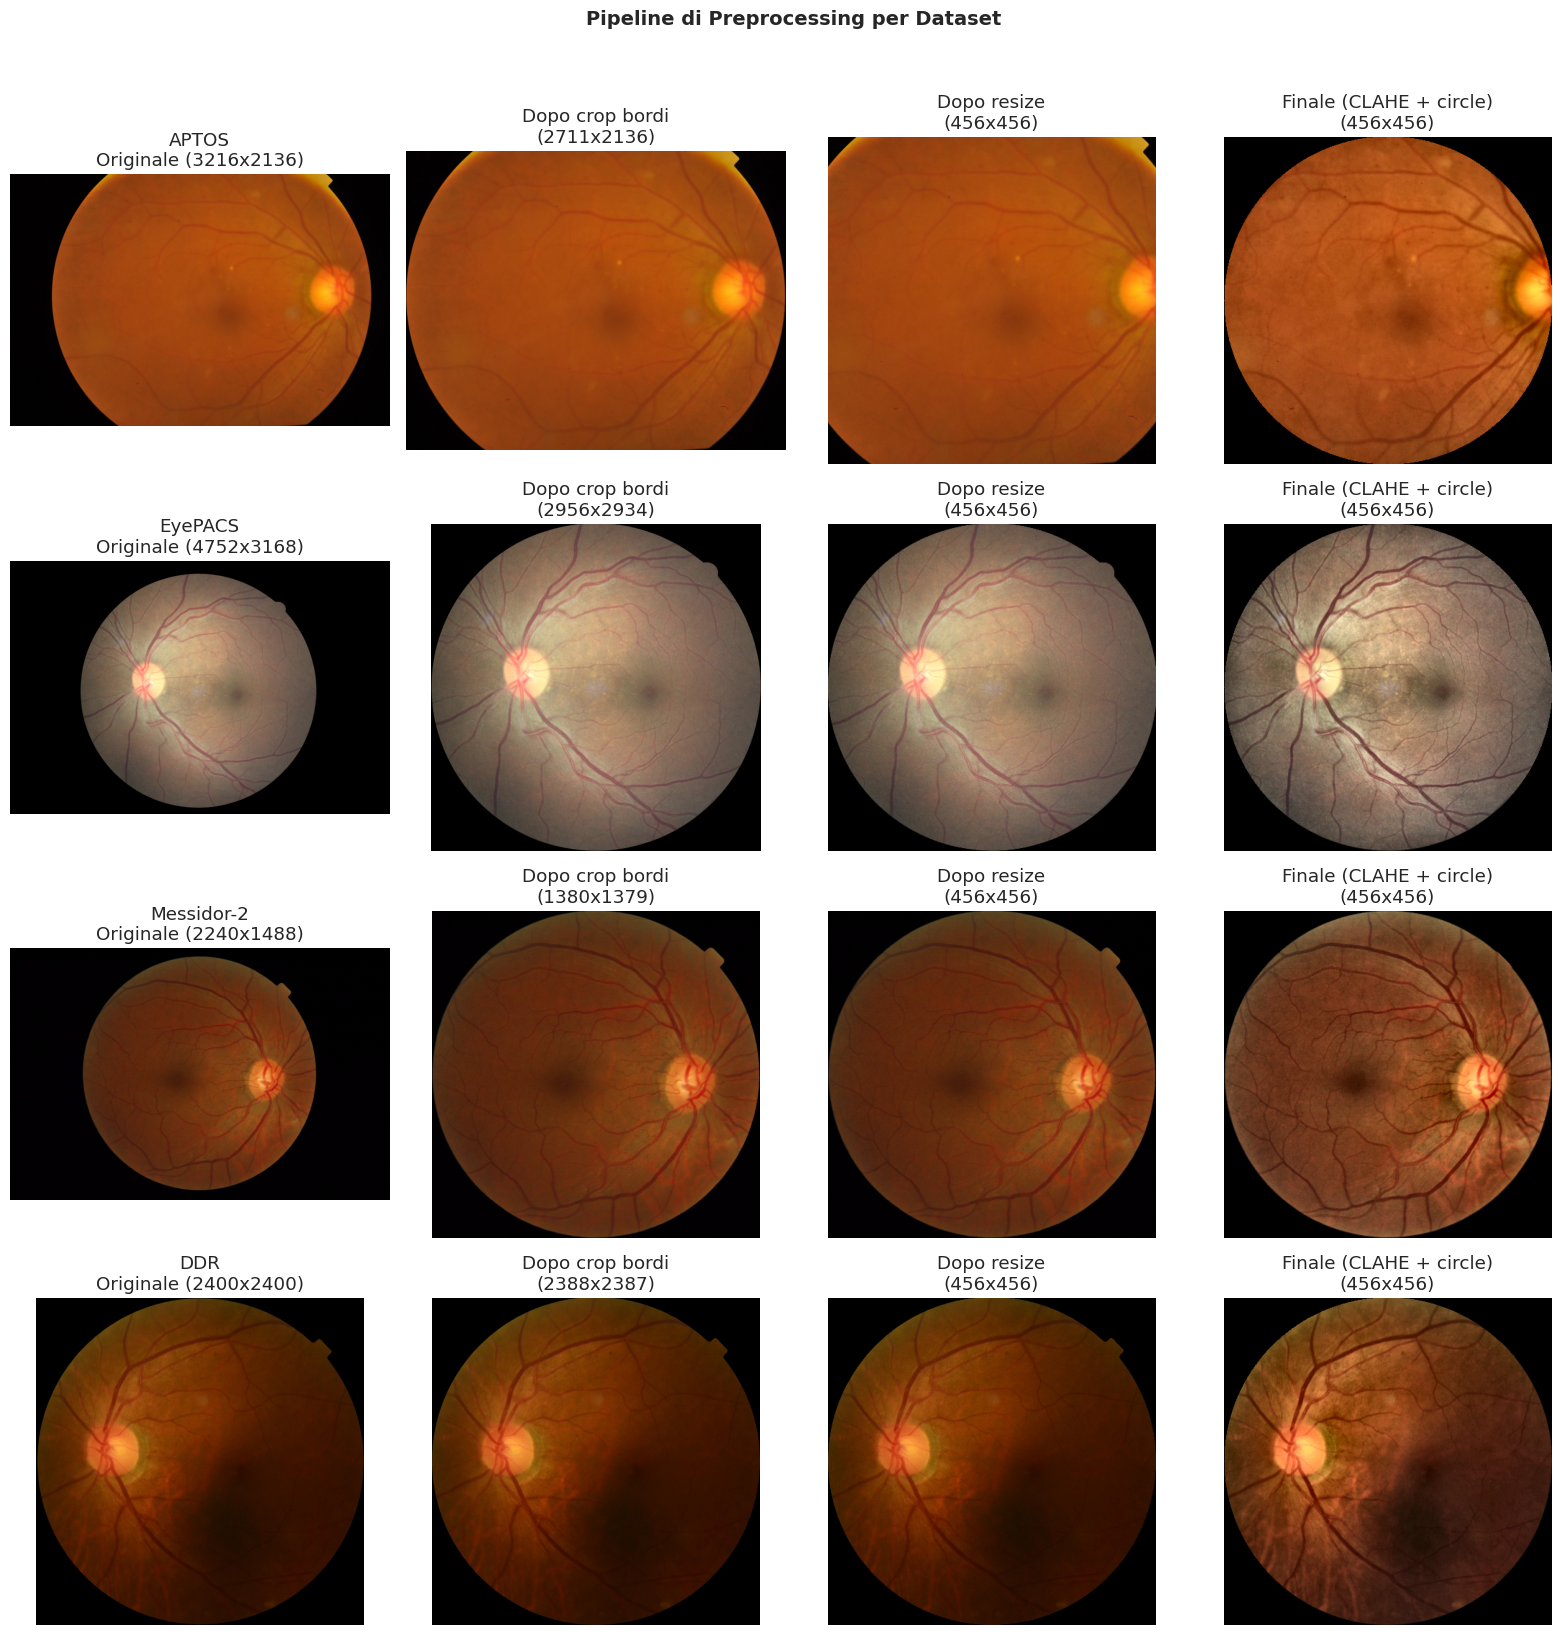

In [10]:
# Visualizzazione del preprocessing step-by-step
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for idx, (dataset_name, img_path) in enumerate(sample_images.items()):
    if img_path is None:
        continue
        
    # Leggi l'immagine originale
    img_original = cv2.imread(str(img_path))
    img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    
    # Step 1: Crop bordi neri
    img_cropped = crop_image_from_gray(img_original.copy())
    img_cropped_rgb = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB)
    
    # Step 2: Resize
    h, w = img_cropped.shape[:2]
    if h > w:
        new_w, new_h = TARGET_SIZE, int(h * TARGET_SIZE / w)
    else:
        new_h, new_w = TARGET_SIZE, int(w * TARGET_SIZE / h)
    img_resized = cv2.resize(img_cropped, (new_w, new_h))
    
    # Crop centrale
    h, w = img_resized.shape[:2]
    start_x, start_y = (w - TARGET_SIZE) // 2, (h - TARGET_SIZE) // 2
    img_resized = img_resized[start_y:start_y + TARGET_SIZE, start_x:start_x + TARGET_SIZE]
    img_resized_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    
    # Step 3: CLAHE + Circle crop (finale)
    img_final = preprocess_image(img_original.copy())
    img_final_rgb = cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB)
    
    # Visualizza
    axes[idx, 0].imshow(img_original_rgb)
    axes[idx, 0].set_title(f'{dataset_name}\nOriginale ({img_original.shape[1]}x{img_original.shape[0]})')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(img_cropped_rgb)
    axes[idx, 1].set_title(f'Dopo crop bordi\n({img_cropped.shape[1]}x{img_cropped.shape[0]})')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(img_resized_rgb)
    axes[idx, 2].set_title(f'Dopo resize\n({TARGET_SIZE}x{TARGET_SIZE})')
    axes[idx, 2].axis('off')
    
    axes[idx, 3].imshow(img_final_rgb)
    axes[idx, 3].set_title(f'Finale (CLAHE + circle)\n({TARGET_SIZE}x{TARGET_SIZE})')
    axes[idx, 3].axis('off')

plt.suptitle('Pipeline di Preprocessing per Dataset', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Salva la figura
output_path = RESULTS_DIR / 'preprocessing_pipeline.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"Figura salvata in: {output_path}")
plt.show()

## 5. Caricamento dei CSV Unificati

In [11]:
# Carica i CSV creati nel notebook precedente
aptos_df = pd.read_csv(PROCESSED_DIR / 'aptos_unified.csv')
eyepacs_df = pd.read_csv(PROCESSED_DIR / 'eyepacs_unified.csv')
messidor_df = pd.read_csv(PROCESSED_DIR / 'messidor2_unified.csv')
ddr_df = pd.read_csv(PROCESSED_DIR / 'ddr_unified.csv')

print("Dataset caricati:")
print(f"  APTOS: {len(aptos_df)} immagini")
print(f"  EyePACS: {len(eyepacs_df)} immagini")
print(f"  Messidor-2: {len(messidor_df)} immagini")
print(f"  DDR: {len(ddr_df)} immagini")
print(f"\nTotale: {len(aptos_df) + len(eyepacs_df) + len(messidor_df) + len(ddr_df)} immagini")

Dataset caricati:
  APTOS: 3296 immagini
  EyePACS: 35126 immagini
  Messidor-2: 1744 immagini
  DDR: 12522 immagini

Totale: 52688 immagini


## 6. Definizione Mapping Percorsi Immagini

In [12]:
def get_image_path(row, dataset_source):
    """
    Costruisce il percorso completo dell'immagine originale.
    
    Args:
        row: Riga del DataFrame
        dataset_source: Nome del dataset ('APTOS', 'EyePACS', 'Messidor2', 'DDR')
        
    Returns:
        Path: Percorso completo all'immagine
    """
    id_code = row['id_code']
    split = row.get('split', 'train')
    
    if dataset_source == 'APTOS':
        # APTOS: immagini in train_images/ o val_images/
        if split == 'train':
            folder = 'train_images'
        else:
            folder = 'val_images'
        # Prova prima .png, poi .jpg
        path_png = DATA_DIR / 'APTOS2019' / folder / f"{id_code}.png"
        if path_png.exists():
            return path_png
        return DATA_DIR / 'APTOS2019' / folder / f"{id_code}.jpg"
    
    elif dataset_source == 'EyePACS':
        # EyePACS: immagini in train/ con estensione .jpeg
        return DATA_DIR / 'EyePACS2015' / 'train' / f"{id_code}.jpeg"
    
    elif dataset_source == 'Messidor2':
        # Messidor-2: l'id_code include gia l'estensione
        return DATA_DIR / 'messidor-2' / 'images' / id_code
    
    elif dataset_source == 'DDR':
        # DDR: immagini in train/, valid/, test/
        base_dir = DATA_DIR / 'DDR Dataset' / 'DDR-dataset' / 'DR_grading' / split
        return base_dir / id_code
    
    return None


def get_output_path(row, dataset_source):
    """
    Costruisce il percorso di output per l'immagine preprocessata.
    
    Args:
        row: Riga del DataFrame
        dataset_source: Nome del dataset
        
    Returns:
        Path: Percorso di output
    """
    id_code = Path(row['id_code']).stem  # Rimuove eventuale estensione
    split = row.get('split', 'train')
    
    # Struttura output: processed/images/{dataset}/{split}/{id_code}.png
    output_dir = PREPROCESSED_DIR / dataset_source.lower() / split
    output_dir.mkdir(parents=True, exist_ok=True)
    
    return output_dir / f"{id_code}.png"

In [13]:
# Verifica dei percorsi per alcuni campioni
print("Verifica percorsi di esempio:")
print("=" * 60)

# APTOS
sample_row = aptos_df.iloc[0]
input_path = get_image_path(sample_row, 'APTOS')
output_path = get_output_path(sample_row, 'APTOS')
print(f"\nAPTOS:")
print(f"  Input: {input_path}")
print(f"  Esiste: {input_path.exists() if input_path else False}")
print(f"  Output: {output_path}")

# EyePACS
sample_row = eyepacs_df.iloc[0]
input_path = get_image_path(sample_row, 'EyePACS')
output_path = get_output_path(sample_row, 'EyePACS')
print(f"\nEyePACS:")
print(f"  Input: {input_path}")
print(f"  Esiste: {input_path.exists() if input_path else False}")
print(f"  Output: {output_path}")

# Messidor-2
sample_row = messidor_df.iloc[0]
input_path = get_image_path(sample_row, 'Messidor2')
output_path = get_output_path(sample_row, 'Messidor2')
print(f"\nMessidor-2:")
print(f"  Input: {input_path}")
print(f"  Esiste: {input_path.exists() if input_path else False}")
print(f"  Output: {output_path}")

# DDR
sample_row = ddr_df.iloc[0]
input_path = get_image_path(sample_row, 'DDR')
output_path = get_output_path(sample_row, 'DDR')
print(f"\nDDR:")
print(f"  Input: {input_path}")
print(f"  Esiste: {input_path.exists() if input_path else False}")
print(f"  Output: {output_path}")

Verifica percorsi di esempio:

APTOS:
  Input: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/APTOS2019/train_images/1ae8c165fd53.png
  Esiste: True
  Output: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/processed/images/aptos/train/1ae8c165fd53.png

EyePACS:
  Input: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/EyePACS2015/train/10_left.jpeg
  Esiste: True
  Output: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/processed/images/eyepacs/train/10_left.png

Messidor-2:
  Input: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/messidor-2/images/20051020_43808_0100_PP.png
  Esiste: True
  Output: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/processed/images/messidor2/test/20051020_43808_0100_PP.png

DDR:
  Input: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/Data/DDR Dataset/DDR-dataset/DR_grading/train/007-0004-000.jpg
  Esiste: True
  Output: /mnt/c/Repository/multi-method-xai-diabetic-reti

## 7. Preprocessing dei Dataset

Procediamo con il preprocessing di tutti i dataset. Questa operazione puo richiedere diverso tempo a seconda del numero di immagini.

In [14]:
def preprocess_dataset(df, dataset_source, apply_circle=True, apply_clahe=True):
    """
    Preprocessa tutte le immagini di un dataset.
    
    Args:
        df: DataFrame con le annotazioni
        dataset_source: Nome del dataset
        apply_circle: Se applicare il crop circolare
        apply_clahe: Se applicare CLAHE
        
    Returns:
        DataFrame aggiornato con la colonna 'preprocessed_path'
    """
    print(f"\nPreprocessing {dataset_source}...")
    print(f"Immagini da processare: {len(df)}")
    
    # Prepara la lista di task
    tasks = []
    preprocessed_paths = []
    
    for idx, row in df.iterrows():
        input_path = get_image_path(row, dataset_source)
        output_path = get_output_path(row, dataset_source)
        
        tasks.append((input_path, output_path, apply_circle, apply_clahe))
        preprocessed_paths.append(str(output_path))
    
    # Processa le immagini
    success_count = 0
    error_count = 0
    errors = []
    
    # Usa tqdm per la progress bar
    for task in tqdm(tasks, desc=f"Processing {dataset_source}"):
        success, path, error = process_single_image(task)
        if success:
            success_count += 1
        else:
            error_count += 1
            errors.append((path, error))
    
    print(f"Completato: {success_count} successi, {error_count} errori")
    
    if errors:
        print(f"Primi 5 errori:")
        for path, err in errors[:5]:
            print(f"  - {path}: {err}")
    
    # Aggiungi la colonna con i percorsi preprocessati
    df = df.copy()
    df['preprocessed_path'] = preprocessed_paths
    
    return df

In [15]:
# Flag per controllare se eseguire il preprocessing completo
# Impostare a True per processare tutti i dataset
# Impostare a False per saltare (utile se gia fatto)

RUN_FULL_PREPROCESSING = True

if RUN_FULL_PREPROCESSING:
    print("="*60)
    print("INIZIO PREPROCESSING COMPLETO")
    print("="*60)
    print(f"\nTotale immagini da processare: {len(aptos_df) + len(eyepacs_df) + len(messidor_df) + len(ddr_df)}")
    print("\nQuesto processo puo richiedere diverso tempo...")
else:
    print("Preprocessing saltato. Impostare RUN_FULL_PREPROCESSING = True per eseguire.")

INIZIO PREPROCESSING COMPLETO

Totale immagini da processare: 52688

Questo processo puo richiedere diverso tempo...


In [16]:
# Preprocessing APTOS
if RUN_FULL_PREPROCESSING:
    aptos_processed = preprocess_dataset(aptos_df, 'APTOS')


Preprocessing APTOS...
Immagini da processare: 3296


Processing APTOS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3296/3296 [13:22<00:00,  4.11it/s]

Completato: 3296 successi, 0 errori


In [17]:
# Preprocessing EyePACS (il piu grande - potrebbe richiedere tempo)
if RUN_FULL_PREPROCESSING:
    eyepacs_processed = preprocess_dataset(eyepacs_df, 'EyePACS')


Preprocessing EyePACS...
Immagini da processare: 35126


Processing EyePACS: 100%|███████████████████████████████████████████████████████████████| 35126/35126 [1:48:48<00:00,  5.38it/s]

Completato: 35126 successi, 0 errori


In [18]:
# Preprocessing Messidor-2
if RUN_FULL_PREPROCESSING:
    messidor_processed = preprocess_dataset(messidor_df, 'Messidor2')


Preprocessing Messidor2...
Immagini da processare: 1744


Processing Messidor2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1744/1744 [03:50<00:00,  7.57it/s]

Completato: 1744 successi, 0 errori


In [19]:
# Preprocessing DDR
if RUN_FULL_PREPROCESSING:
    ddr_processed = preprocess_dataset(ddr_df, 'DDR')


Preprocessing DDR...
Immagini da processare: 12522


Processing DDR:  14%|███████████████████████████████████▋                                                                                                                                                                                                                         | 1767/12522 [03:43<22:01,  8.14it/s]Corrupt JPEG data: 40 extraneous bytes before marker 0xd9
Corrupt JPEG data: 37 extraneous bytes before marker 0xd9
Processing DDR:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 10964/12522 [23:59<04:52,  5.33it/s]Corrupt JPEG data: 36 extraneous bytes before marker 0xd9
Corrupt JPEG data: 36 extraneous bytes before marker 0xd9
Processing DDR: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Completato: 12522 successi, 0 errori


## 8. Salvataggio CSV Aggiornati

In [20]:
if RUN_FULL_PREPROCESSING:
    # Salva i CSV con i percorsi delle immagini preprocessate
    aptos_processed.to_csv(PROCESSED_DIR / 'aptos_preprocessed.csv', index=False)
    eyepacs_processed.to_csv(PROCESSED_DIR / 'eyepacs_preprocessed.csv', index=False)
    messidor_processed.to_csv(PROCESSED_DIR / 'messidor2_preprocessed.csv', index=False)
    ddr_processed.to_csv(PROCESSED_DIR / 'ddr_preprocessed.csv', index=False)
    
    # Crea anche il CSV combinato per il training
    combined_processed = pd.concat([
        aptos_processed[aptos_processed['split'] == 'train'],
        eyepacs_processed
    ], ignore_index=True)
    combined_processed.to_csv(PROCESSED_DIR / 'combined_train_preprocessed.csv', index=False)
    
    print("CSV salvati:")
    print(f"  - aptos_preprocessed.csv: {len(aptos_processed)} righe")
    print(f"  - eyepacs_preprocessed.csv: {len(eyepacs_processed)} righe")
    print(f"  - messidor2_preprocessed.csv: {len(messidor_processed)} righe")
    print(f"  - ddr_preprocessed.csv: {len(ddr_processed)} righe")
    print(f"  - combined_train_preprocessed.csv: {len(combined_processed)} righe")

CSV salvati:
  - aptos_preprocessed.csv: 3296 righe
  - eyepacs_preprocessed.csv: 35126 righe
  - messidor2_preprocessed.csv: 1744 righe
  - ddr_preprocessed.csv: 12522 righe
  - combined_train_preprocessed.csv: 38056 righe


## 9. Verifica Immagini Preprocessate

Figura salvata in: /mnt/c/Repository/multi-method-xai-diabetic-retinopathy/results/preprocessed_samples.png


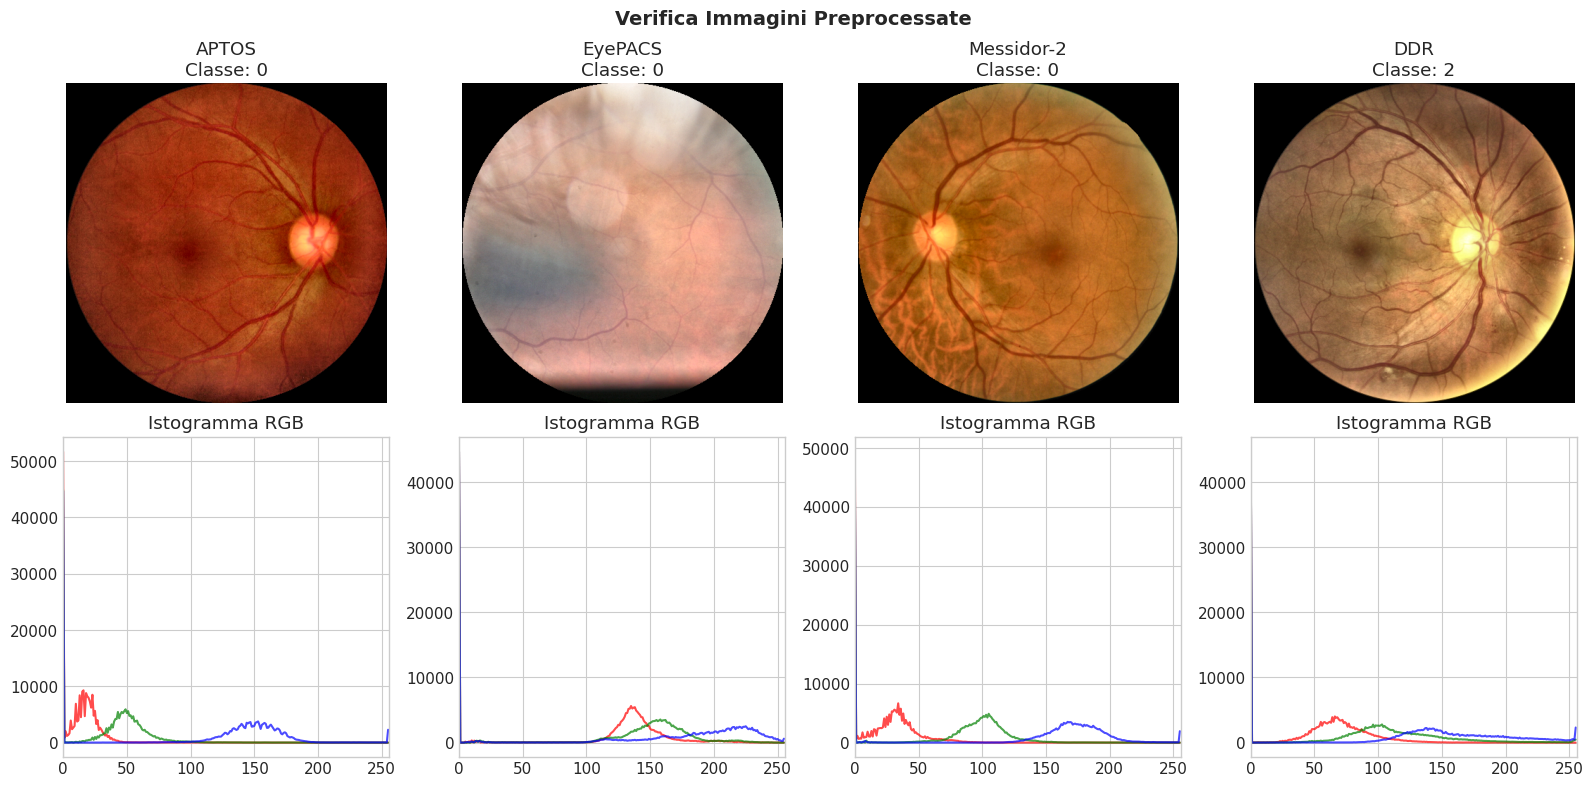

In [21]:
# Visualizza alcune immagini preprocessate per verifica
if RUN_FULL_PREPROCESSING:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    datasets = [
        ('APTOS', aptos_processed),
        ('EyePACS', eyepacs_processed),
        ('Messidor-2', messidor_processed),
        ('DDR', ddr_processed)
    ]
    
    for idx, (name, df) in enumerate(datasets):
        # Seleziona un campione casuale
        sample = df.sample(1).iloc[0]
        
        # Carica immagine preprocessata
        img_path = sample['preprocessed_path']
        img = cv2.imread(img_path)
        
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Mostra immagine
            axes[0, idx].imshow(img_rgb)
            axes[0, idx].set_title(f'{name}\nClasse: {sample["diagnosis"]}')
            axes[0, idx].axis('off')
            
            # Mostra istogramma dei canali
            colors = ('r', 'g', 'b')
            for i, color in enumerate(colors):
                hist = cv2.calcHist([img], [i], None, [256], [0, 256])
                axes[1, idx].plot(hist, color=color, alpha=0.7)
            axes[1, idx].set_title(f'Istogramma RGB')
            axes[1, idx].set_xlim([0, 256])
    
    plt.suptitle('Verifica Immagini Preprocessate', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Salva figura
    output_path = RESULTS_DIR / 'preprocessed_samples.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"Figura salvata in: {output_path}")
    plt.show()

## 10. Statistiche Finali

In [22]:
if RUN_FULL_PREPROCESSING:
    # Conta le immagini preprocessate
    def count_preprocessed_images(directory):
        """Conta il numero di immagini PNG in una directory e sottodirectory."""
        return len(list(Path(directory).rglob('*.png')))
    
    print("Statistiche Immagini Preprocessate")
    print("=" * 60)
    
    for dataset in ['aptos', 'eyepacs', 'messidor2', 'ddr']:
        dataset_dir = PREPROCESSED_DIR / dataset
        if dataset_dir.exists():
            count = count_preprocessed_images(dataset_dir)
            print(f"{dataset.upper()}: {count:,} immagini")
            
            # Mostra split
            for split_dir in dataset_dir.iterdir():
                if split_dir.is_dir():
                    split_count = len(list(split_dir.glob('*.png')))
                    print(f"  - {split_dir.name}: {split_count:,}")
    
    total = count_preprocessed_images(PREPROCESSED_DIR)
    print(f"\nTOTALE: {total:,} immagini preprocessate")

Statistiche Immagini Preprocessate
APTOS: 3,296 immagini
  - train: 2,930
  - valid: 366
EYEPACS: 35,126 immagini
  - train: 35,126
MESSIDOR2: 1,744 immagini
  - test: 1,744
DDR: 12,522 immagini
  - test: 3,759
  - train: 6,260
  - valid: 2,503

TOTALE: 52,688 immagini preprocessate


In [23]:
if RUN_FULL_PREPROCESSING:
    # Calcola spazio occupato
    def get_directory_size(directory):
        """Calcola la dimensione totale di una directory in bytes."""
        total = 0
        for path in Path(directory).rglob('*'):
            if path.is_file():
                total += path.stat().st_size
        return total
    
    def format_size(size_bytes):
        """Formatta la dimensione in formato leggibile."""
        for unit in ['B', 'KB', 'MB', 'GB']:
            if size_bytes < 1024:
                return f"{size_bytes:.1f} {unit}"
            size_bytes /= 1024
        return f"{size_bytes:.1f} TB"
    
    print("\nSpazio Occupato")
    print("=" * 60)
    
    for dataset in ['aptos', 'eyepacs', 'messidor2', 'ddr']:
        dataset_dir = PREPROCESSED_DIR / dataset
        if dataset_dir.exists():
            size = get_directory_size(dataset_dir)
            print(f"{dataset.upper()}: {format_size(size)}")
    
    total_size = get_directory_size(PREPROCESSED_DIR)
    print(f"\nTOTALE: {format_size(total_size)}")


Spazio Occupato
APTOS: 876.7 MB
EYEPACS: 9.3 GB
MESSIDOR2: 462.2 MB
DDR: 3.3 GB

TOTALE: 13.9 GB


## 11. Conclusioni

### Riepilogo del Preprocessing

**Operazioni eseguite:**
1. Rimozione bordi neri (crop automatico)
2. Ridimensionamento a 456x456 pixel
3. Applicazione CLAHE per miglioramento contrasto
4. Applicazione maschera circolare

**Output generati:**
- Immagini preprocessate in `Data/processed/images/{dataset}/{split}/`
- CSV aggiornati con percorsi alle immagini preprocessate

### Prossimi Passi
1. Creazione dei DataLoader PyTorch
2. Definizione delle trasformazioni di data augmentation
3. Setup del modello EfficientNet-B5
4. Training del modello